# Script for Training: V1_5_5

In [1]:
#V1_5_5:
#functions in a seperate script

In [2]:
#save files to folders
save_folder = "run11_test"

train_on_folder = False     #eather train on just one file or on more folders of trainingsdata
train_data_path = "/eos/home-f/frehm/TF2/Data/EleEscan_1_1/EleEscan_1_1.h5"   #"C:\\Users/frehm/cernbox/TF/Data/E1/EleEscan_1_1.h5" #data file
train_folder_path = "/eos/home-f/frehm/TF2/Data//"                            #there has to be a folder inside

nb_epochs = 100
percent = 100                        #take just 10 percent of all data for training and testing
keras_dformat = 'channels_first'    #last for CPU, first for GPU
latent_size = 200
batch_size =  128 #128              #batch_size must be less or equal test size, otherwise error

from Models_V1_4 import generator, discriminator
from Functions_v1 import *

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
#imports 
from __future__ import print_function
import os
#use this on top of script, before the tensorflow library imports
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"     #device 1
import tensorflow as tf

#!/usr/bin/env python
# -*- coding: utf-8 -*-
from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
import argparse
from six.moves import range
import sys
import h5py 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
#import trainingsdata
X,y = import_data(train_on_folder, train_data_path, train_folder_path)
print('*************************************************************************************') 

#create output folders for saving files and weights
create_folder(save_folder+'/')
create_folder(save_folder+'/Weights/')
create_folder(save_folder+'/Weights/disc')
create_folder(save_folder+'/Weights/gen')
create_folder(save_folder+'/Pickle/')
create_folder(save_folder+'/Save_Images/')
print('*************************************************************************************')

#do data preperation    
X_train, X_test, y_train, y_test, ecal_train, ecal_test, nb_train, nb_test = data_preperation(X, y, keras_dformat, batch_size, percent)
print("X_train_shape: ", X_train.shape)
print("X_test_shape: ", X_test.shape)
print("ecal_train_shape: ", ecal_train.shape)
print("ecal_test_shape: ", ecal_test.shape)
print('*************************************************************************************')


X_Shape (Imported Data):  (10000, 25, 25, 25)
Länge y:  10000
*************************************************************************************
Directory  run11_test/  already exists
Directory  run11_test/Weights/  already exists
Directory  run11_test/Weights/disc  already exists
Directory  run11_test/Weights/gen  already exists
Directory  run11_test/Pickle/  already exists
Directory  run11_test/Save_Images/  already exists
*************************************************************************************
X_train_shape:  (9000, 1, 25, 25, 25)
X_test_shape:  (1000, 1, 25, 25, 25)
ecal_train_shape:  (9000, 1)
ecal_test_shape:  (1000, 1)
*************************************************************************************


In [5]:
#build networks and preprocess trainingsdata
session = tf.compat.v1.Session()

verbose = 'true'
generator = generator(latent_size, keras_dformat = keras_dformat)
discriminator = discriminator(keras_dformat = keras_dformat)

print ("TF Version: ",tf.__version__)
print('[INFO] Building discriminator')
discriminator.compile(
    optimizer="adam",
    #optimizer=RMSprop(),
    loss=['binary_crossentropy', 'mean_absolute_percentage_error', 'mean_absolute_percentage_error'],
    loss_weights=[6, 0.2, 0.1]
)

# build the generator
print('[INFO] Building generator')
generator.compile(
    optimizer="adam",
    #optimizer=RMSprop(),
    loss='binary_crossentropy'
)

#Building compined model
latent = tf.keras.Input(shape=(latent_size, ), name='combined_z')
fake_image = generator(latent)
discriminator.trainable = False
fake, aux, ecal = discriminator(fake_image)
combined = tf.keras.Model(
    inputs=[latent],
    outputs=[fake, aux, ecal],
    name='combined_model'
)
combined.compile(
    optimizer="adam",
    #optimizer=RMSprop(),
    loss=['binary_crossentropy', 'mean_absolute_percentage_error', 'mean_absolute_percentage_error'],
    loss_weights=[6, 0.2, 0.1]
)

TF Version:  2.0.0-beta1
[INFO] Building discriminator
[INFO] Building generator


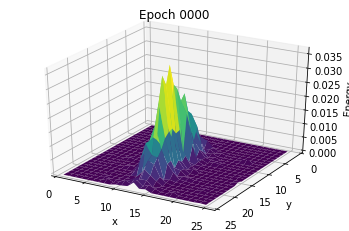

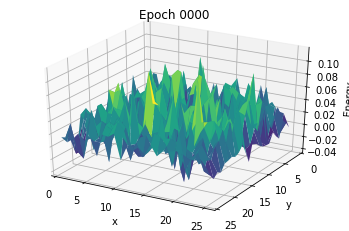

gen_aux:   [4.45791772]     gen_ecal:   [8.91583544]
disc_aux:  [[0.00306955]]    disc_ecal:  [[343.15753]]


In [6]:
#plots during training

#%matplotlib notebook            #this is for 3D projection
epoch = 0
#function for plotting a training images
plot_images(X, epoch, save_folder, save=False, number=1)

#plot of generated image
np.random.seed(1)     
noise, gen_aux, generator_input, gen_ecal = func_for_gen(1,latent_size=latent_size)
np.random.seed(None)
generated_images = generator.predict(generator_input, verbose=False)
generated_images = np.squeeze(generated_images, axis=(1,))
Xgen = generated_images
plot_images(Xgen, epoch, save_folder, save=True, number=1)
    
Xgen=Xgen[0]
gen_imgs = tf.expand_dims(tf.expand_dims(Xgen,0),0)
print("gen_aux:  ", gen_aux[0], "    gen_ecal:  ", gen_ecal[0])
print("disc_aux: ", discriminator.predict(gen_imgs)[1], "   disc_ecal: ", discriminator.predict(gen_imgs)[2] )



Epoch 1 of 100
 1/70 [..............................] - ETA: 0sWARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
70/70 [==============================] - 174s 2s/step

Testing for epoch 1:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 1159.33 | 1.83            | 147.86| 11187.80
generator (test)       | 387.74 | 4.39            | 32.83| 3543.78
discriminator (train)  | 2649.95 | 0.98            | 197.75| 26045.28
discriminator (test)   | 170.66 | 0.13            | 51.68| 1623.07


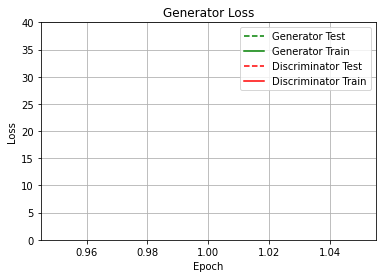

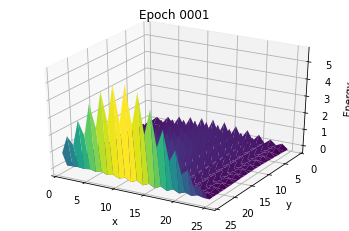

Time for Epoch: 00:03:05

Epoch 2 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 2:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 184.31 | 2.63            | 35.42| 1628.96
generator (test)       | 171.01 | 3.42            | 35.67| 1428.03
discriminator (train)  | 119.12 | 0.30            | 49.23| 1085.09
discriminator (test)   | 77.90 | 0.04            | 32.74| 724.01


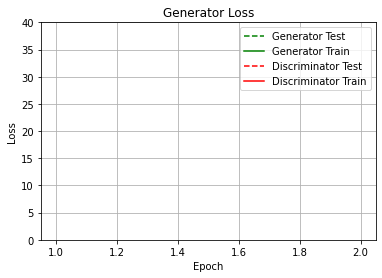

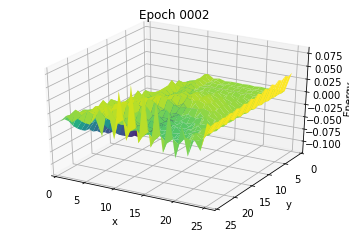

Time for Epoch: 00:02:45

Epoch 3 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 3:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 112.68 | 3.08            | 34.83| 874.42
generator (test)       | 172.48 | 3.68            | 32.65| 1433.14
discriminator (train)  | 57.82 | 0.23            | 31.66| 506.02
discriminator (test)   | 79.10 | 0.08            | 25.89| 749.30


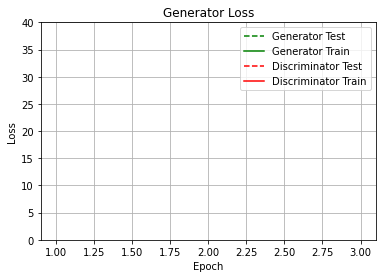

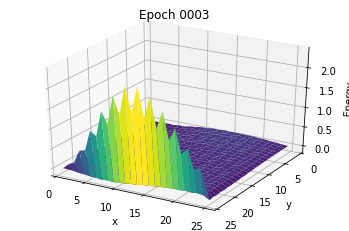

Time for Epoch: 00:02:45

Epoch 4 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 4:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 127.13 | 3.18            | 47.12| 989.40
generator (test)       | 58.45 | 3.31            | 37.11| 312.10
discriminator (train)  | 64.14 | 0.39            | 34.65| 553.78
discriminator (test)   | 22.77 | 0.20            | 25.34| 170.47


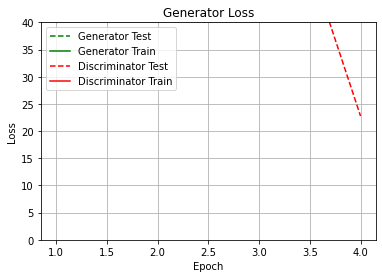

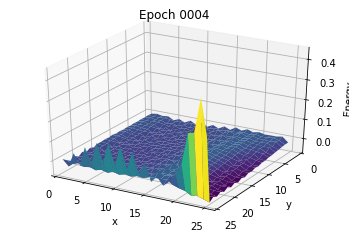

Time for Epoch: 00:02:45

Epoch 5 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 5:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 133.46 | 3.10            | 42.17| 1065.33
generator (test)       | 65.11 | 2.99            | 37.19| 393.81
discriminator (train)  | 65.49 | 0.31            | 28.70| 579.89
discriminator (test)   | 24.15 | 0.14            | 23.44| 189.70


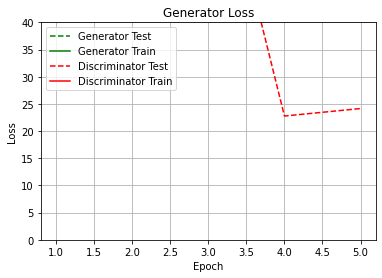

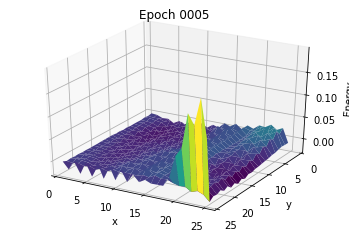

Time for Epoch: 00:02:45

Epoch 6 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 6:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 83.40 | 3.01            | 39.10| 575.52
generator (test)       | 59.33 | 3.75            | 34.92| 298.45
discriminator (train)  | 36.44 | 0.29            | 28.30| 291.86
discriminator (test)   | 22.71 | 0.40            | 29.95| 148.48


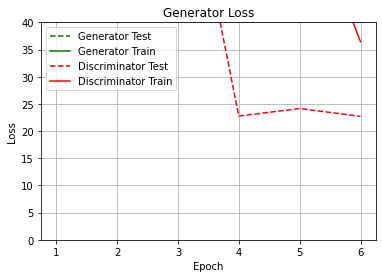

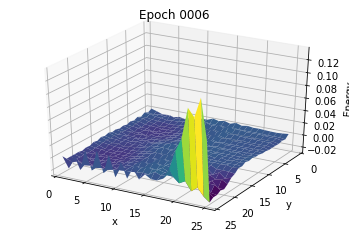

Time for Epoch: 00:02:48

Epoch 7 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 7:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 53.37 | 2.85            | 39.63| 283.98
generator (test)       | 59.92 | 2.27            | 43.53| 373.45
discriminator (train)  | 20.39 | 0.29            | 28.85| 129.87
discriminator (test)   | 26.48 | 0.12            | 25.53| 214.66


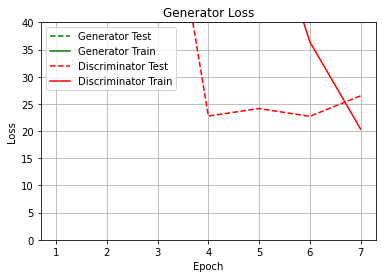

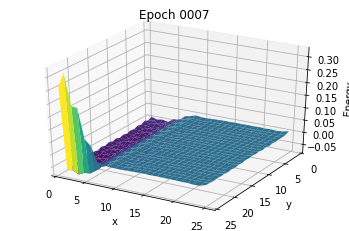

Time for Epoch: 00:02:45

Epoch 8 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 8:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 52.68 | 2.94            | 40.36| 269.59
generator (test)       | 64.57 | 2.63            | 38.21| 410.87
discriminator (train)  | 20.61 | 0.30            | 28.96| 131.67
discriminator (test)   | 24.64 | 0.13            | 24.65| 197.80


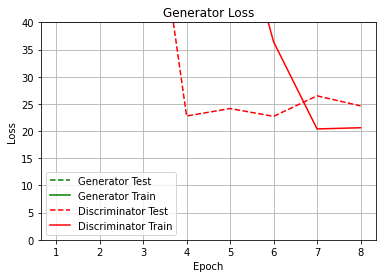

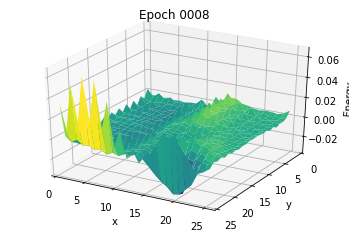

Time for Epoch: 00:02:47

Epoch 9 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 9:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 43.70 | 2.78            | 40.18| 189.22
generator (test)       | 36.87 | 2.74            | 43.31| 117.78
discriminator (train)  | 17.14 | 0.30            | 28.52| 97.71
discriminator (test)   | 11.92 | 0.14            | 30.20| 52.58


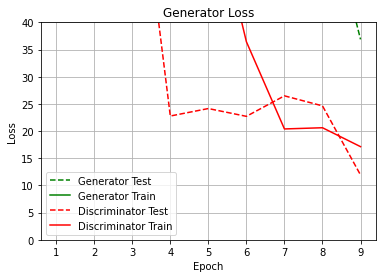

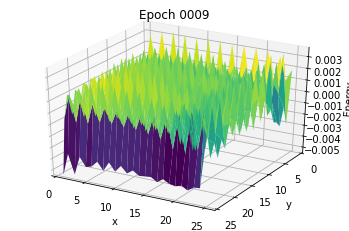

Time for Epoch: 00:02:45

Epoch 10 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 10:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 48.85 | 2.72            | 42.39| 240.04
generator (test)       | 39.89 | 2.30            | 36.77| 185.81
discriminator (train)  | 18.26 | 0.31            | 30.40| 103.64
discriminator (test)   | 15.50 | 0.14            | 21.74| 104.98


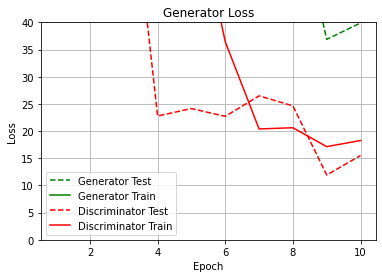

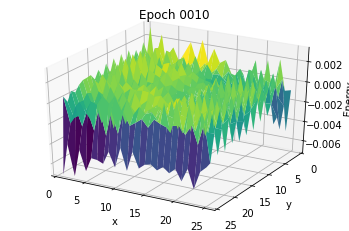

Time for Epoch: 00:02:45

Epoch 11 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 11:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 40.74 | 2.50            | 41.44| 174.28
generator (test)       | 33.53 | 3.08            | 42.10| 66.55
discriminator (train)  | 15.41 | 0.32            | 31.77| 72.44
discriminator (test)   | 9.97 | 0.17            | 27.42| 36.21


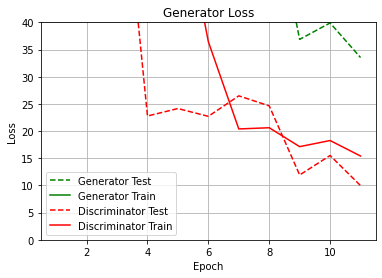

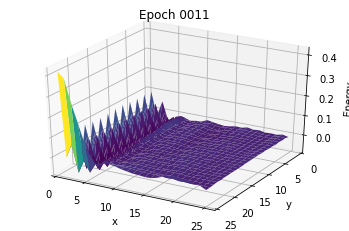

Time for Epoch: 00:02:45

Epoch 12 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 12:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 33.78 | 2.64            | 40.38| 98.72
generator (test)       | 37.75 | 3.40            | 38.08| 97.22
discriminator (train)  | 13.51 | 0.34            | 32.97| 49.31
discriminator (test)   | 12.90 | 0.25            | 32.89| 49.06


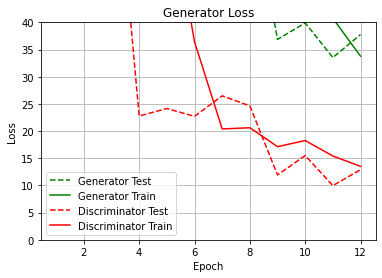

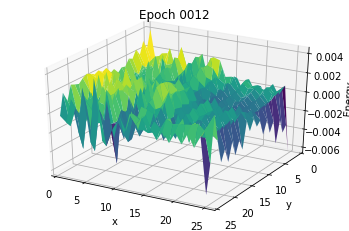

Time for Epoch: 00:02:45

Epoch 13 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 13:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 35.71 | 2.69            | 39.63| 116.18
generator (test)       | 32.18 | 3.33            | 45.89| 30.45
discriminator (train)  | 14.29 | 0.39            | 32.83| 54.24
discriminator (test)   | 8.53 | 0.20            | 29.37| 15.47


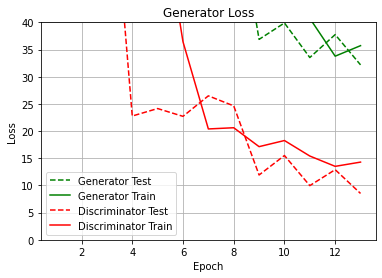

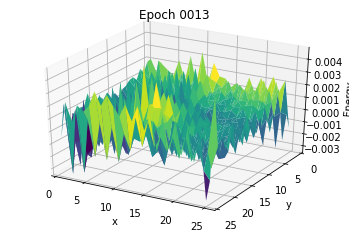

Time for Epoch: 00:02:46

Epoch 14 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 14:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 35.88 | 2.96            | 40.34| 100.66
generator (test)       | 43.11 | 3.73            | 34.17| 138.80
discriminator (train)  | 12.52 | 0.33            | 30.09| 45.64
discriminator (test)   | 11.94 | 0.10            | 21.92| 71.24


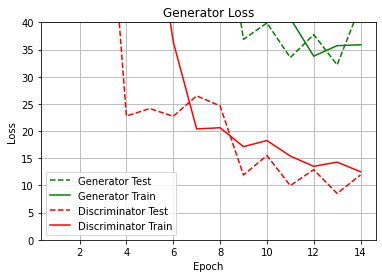

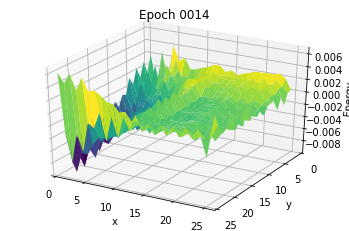

Time for Epoch: 00:02:45

Epoch 15 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 15:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 34.28 | 2.67            | 42.01| 98.36
generator (test)       | 29.32 | 3.21            | 37.10| 26.36
discriminator (train)  | 13.74 | 0.34            | 33.44| 50.83
discriminator (test)   | 7.65 | 0.18            | 26.05| 14.52


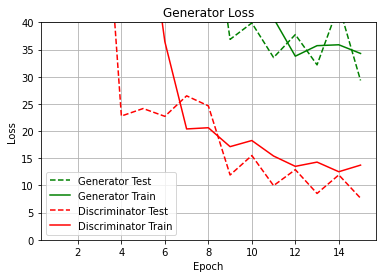

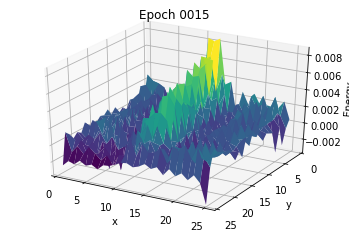

Time for Epoch: 00:02:46

Epoch 16 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 16:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 32.46 | 2.58            | 39.84| 89.69
generator (test)       | 25.90 | 2.13            | 49.59| 32.83
discriminator (train)  | 12.67 | 0.37            | 31.11| 42.72
discriminator (test)   | 8.88 | 0.21            | 29.60| 18.18


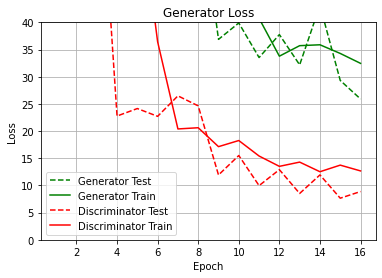

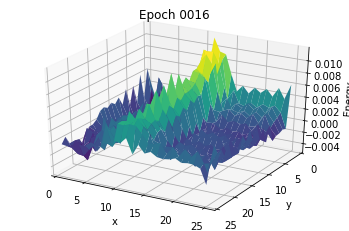

Time for Epoch: 00:02:45

Epoch 17 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 17:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 31.16 | 2.72            | 34.68| 78.96
generator (test)       | 38.76 | 3.99            | 47.45| 52.85
discriminator (train)  | 11.55 | 0.34            | 29.27| 36.65
discriminator (test)   | 12.00 | 0.47            | 32.62| 27.56


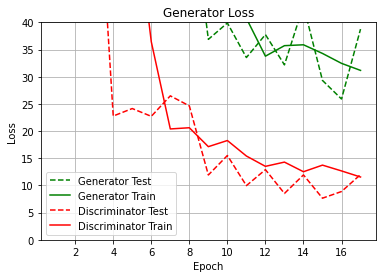

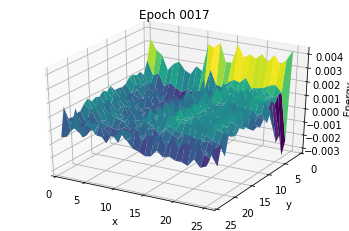

Time for Epoch: 00:02:45

Epoch 18 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 18:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 28.97 | 2.49            | 35.48| 69.95
generator (test)       | 29.13 | 2.11            | 54.09| 56.71
discriminator (train)  | 11.52 | 0.38            | 29.12| 34.20
discriminator (test)   | 11.40 | 0.32            | 33.46| 29.48


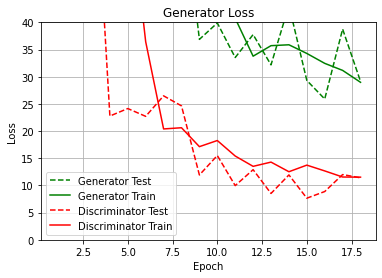

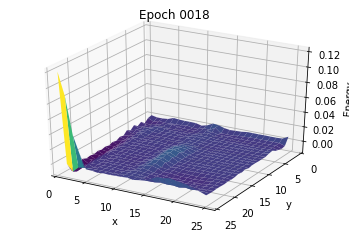

Time for Epoch: 00:02:45

Epoch 19 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 19:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 27.37 | 2.01            | 35.81| 81.34
generator (test)       | 27.60 | 2.17            | 39.17| 68.05
discriminator (train)  | 11.55 | 0.44            | 27.09| 35.40
discriminator (test)   | 9.73 | 0.32            | 25.17| 29.21


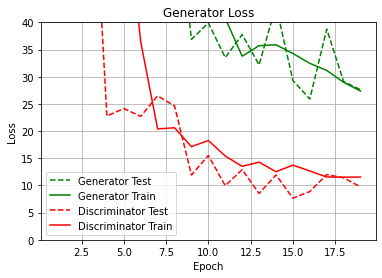

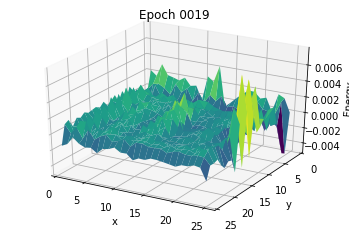

Time for Epoch: 00:02:45

Epoch 20 of 100
70/70 [==============================] - 158s 2s/step

Testing for epoch 20:
component              | total_loss | fake/true_loss  | AUX_loss| ECAL_loss
-----------------------------------------------------------------
generator (train)      | 26.24 | 1.63            | 35.37| 93.84
generator (test)       | 18.83 | 1.77            | 28.76| 24.27
discriminator (train)  | 12.54 | 0.42            | 25.13| 50.18
discriminator (test)   | 6.63 | 0.25            | 19.62| 12.50


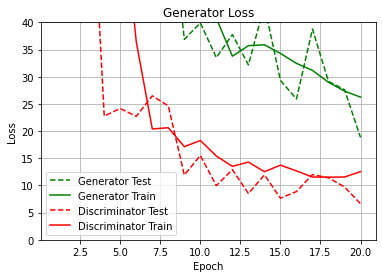

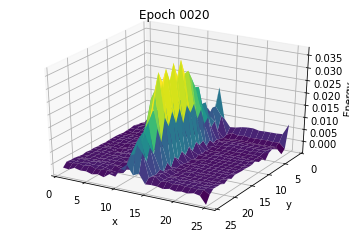

Time for Epoch: 00:02:45

Epoch 21 of 100
43/70 [=================>............] - ETA: 1:00

In [ ]:
#set up training
train_history = defaultdict(list)   #create a dict with an empty list 
test_history = defaultdict(list)

import time
start_training = time.time()

for epoch in range(nb_epochs):
    start_epoch = time.time()
    print('\nEpoch {} of {}'.format(epoch + 1, nb_epochs))
    nb_batches = int(X_train.shape[0] / batch_size)
    if verbose:
        progress_bar = tf.keras.utils.Progbar(target=nb_batches)
    epoch_gen_loss = []
    epoch_disc_loss = []
    for index in range(nb_batches):
        if verbose:
            progress_bar.update(index+1)
        else:
            if index % 100 == 0:
                print('processed {}/{} batches'.format(index + 1, nb_batches))

       #create batches
        image_batch =   X_train[index * batch_size:(index + 1) * batch_size]
        energy_batch =  y_train[index * batch_size:(index + 1) * batch_size]
        ecal_batch = ecal_train[index * batch_size:(index + 1) * batch_size]

    #disc training 
        noise, gen_aux, generator_input, gen_ecal = func_for_gen(nb_test=batch_size,latent_size=latent_size) #len has to be batch size, because of bit_flip used below
        generated_images = generator.predict(generator_input, verbose=0)

        #outputs of train_on_batch is the loss as scalar
        real_batch_loss = discriminator.train_on_batch(image_batch, [bit_flip(np.ones(batch_size)), energy_batch, ecal_batch])
        fake_batch_loss = discriminator.train_on_batch(generated_images, [bit_flip(np.zeros(batch_size)), gen_aux, gen_ecal])

        epoch_disc_loss.append([
            (a + b) / 2 for a, b in zip(real_batch_loss, fake_batch_loss)
        ])

    #generator training
        gen_fake_labels = np.ones(batch_size)
        gen_losses = []

        for _ in range(2):                                                       #Berechnet 2 mal den Loss
            noise, gen_aux, generator_input, gen_ecal = func_for_gen(nb_test=batch_size,latent_size=latent_size) #len has to be batch size, because of bit_flip used below

            gen_losses.append(combined.train_on_batch(
                [generator_input],
                [gen_fake_labels, gen_aux.reshape((-1, 1)), gen_ecal]))

        epoch_gen_loss.append([
            (a + b) / 2 for a, b in zip(*gen_losses)
        ])
#############################################################################################
    #Run the testing with generated images and training images
    print('\nTesting for epoch {}:'.format(epoch + 1))

    noise, gen_aux, generator_input, gen_ecal = func_for_gen(nb_test,latent_size=latent_size)
    generated_images = generator.predict(generator_input, verbose=False)
    gen_aux = np.squeeze(gen_aux, axis=(1,))   #input array, but with all dimensions of length 1 removed

    #Add the test data with the generated images
    X = np.concatenate((X_test, generated_images))
    y = np.array([1] * nb_test + [0] * nb_test)      #true/false for real images/generated fakes
    ecal = np.concatenate((ecal_test, gen_ecal))
    aux_y = np.concatenate((y_test, gen_aux), axis=0)
    #print("generated images shape: ", generated_images.shape)
    #print("ecal shape: ", ecal.shape)
    #print("X shape: ", X.shape)
    #print("y shape: ", y.shape)
    #print("sampled energies shape: ", gen_aux.shape)
    #print("aux shape: ", aux_y.shape)
    discriminator_test_loss = discriminator.evaluate(
        X, [y, aux_y, ecal], verbose=False, batch_size=batch_size)

    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)   #mean disc loss for all epochs

    noise, gen_aux, generator_input, gen_ecal = func_for_gen(2*nb_test,latent_size=latent_size)
    gen_fake_labels = np.ones(2 * nb_test)  
    generator_test_loss = combined.evaluate(generator_input,
                                            [gen_fake_labels, gen_aux.reshape((-1, 1)), gen_ecal], verbose=False, batch_size=batch_size)
    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
###################################################################################################
    #create lists for train/test history
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)

    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)

    #create table
    loss_table(train_history,test_history)
    
    #plot every tenth epoch the loss graph
    if (epoch-1)%1 == 0 and epoch >= 0:
        plot_loss(train_history, test_history)
        noise, gen_aux, generator_input, gen_ecal = func_for_gen(1,latent_size=latent_size)
        generated_images = generator.predict(generator_input, verbose=False)
        generated_images = np.squeeze(generated_images, axis=(1,))
        Xgen = generated_images
        plot_images(Xgen, epoch+1, save_folder, save=True, number=1)

    end_batch = time.time()
    e = int(end_batch-start_epoch)
    print('Time for Epoch: {:02d}:{:02d}:{:02d}'.format(e // 3600, (e % 3600 // 60), e % 60))

    # save weights every epoch
    generator.save_weights(save_folder+"/Weights/gen/params_generator_epoch_"+str(epoch)+".hdf5",overwrite=True)
    discriminator.save_weights(save_folder+"/Weights/disc/params_discriminator_epoch_"+str(epoch)+".hdf5",overwrite=True)
    
    #save history
    pickle.dump([train_history, test_history], open(save_folder+'/Pickle/3dgan-history.pkl', 'wb'))
    pickle.dump({'train': train_history, 'test': test_history}, open(save_folder+'/Pickle/3dgan-history_dict.pkl', 'wb'))
end_training = time.time()
e = int(end_training-start_training)
print('\nTotal Trainingstime: {:02d}:{:02d}:{:02d}'.format(e // 3600, (e % 3600 // 60), e % 60))

reset_Session() #this function should reset the connection to the GPU after each run

In [ ]:
error

In [ ]:
#import pickle history
import pickle
pickle_import = pickle.load( open( '/eos/home-f/frehm/TF2/Skripts/F02-03/Runs/run11/run11/Pickle/3dgan-history.pkl', "rb" ) )
#print((pickle_import))
train_history = pickle_import[0]
test_history  = pickle_import[1]

In [ ]:
#plot loss graph
plot_loss(train_history, test_history)

In [ ]:
#print table
loss_table(train_history,test_history)

In [ ]:
#plot a trainingsimage

#this is for 3D projection
#%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  #I need this for my plot

#plot some training images
plot_images(X, 0, save_folder, save=False, number=1)

In [ ]:
#generate images
def generate_images(number_images,load_weights_path,plot=True,number_plots=1):
    generator.load_weights(load_weights_path)
    np.random.seed(1)     #gen_aux:   [4.45791772]     gen_ecal:   [8.91583544]
    noise, gen_aux, generator_input, gen_ecal = func_for_gen(number_images,latent_size=latent_size)
    np.random.seed(None)
    generated_images = generator.predict(generator_input, verbose=False)
    generated_images = np.squeeze(generated_images, axis=(1,))
    Xgen = generated_images
    #print(Xgen.shape)
    if plot == True:
        plot_images(Xgen, 0, save_folder, save=False, number=number_plots)
    Xgen=Xgen[0]
    discriminator.load_weights(load_weights_path_disc)
    gen_imgs = tf.expand_dims(tf.expand_dims(Xgen,0),0)
    print("gen_aux:  ", gen_aux[0], "    gen_ecal:  ", gen_ecal[0])
    print("disc_aux: ", discriminator.predict(gen_imgs)[1], "   disc_ecal: ", discriminator.predict(gen_imgs)[2] )
    return generated_images

try:    
    generator = generator(latent_size,keras_dformat=keras_dformat)
    generator.compile(optimizer="adam", loss='binary_crossentropy')
except:
    hhh="good for nothing"
    
load_weights_path = "/eos/home-f/frehm/TF2/Skripts/F02-03/Runs/run11/run11/Weights/gen/params_generator_epoch_1"+".hdf5"    
load_weights_path_disc = "/eos/home-f/frehm/TF2/Skripts/F02-03/Runs/run11/run11/Weights/disc/params_discriminator_epoch_1"+".hdf5"    

generated_images = generate_images(1, load_weights_path, plot = True, number_plots=1)

In [ ]:
#load discriminator
#print(generated_images.shape)
load_weights_path_disc = "/eos/home-f/frehm/TF2/Skripts/F02-03/Runs/run11/run11/Weights/disc/params_discriminator_epoch_1"+".hdf5"  
discriminator.load_weights(load_weights_path_disc)

gen_imgs = (tf.expand_dims(generated_images,1))
#print(gen_imgs.shape)
print("generated: ", discriminator.predict(gen_imgs))

train_imgs = (tf.expand_dims(X[:5],1))
#print(train_imgs.shape)
#print("train: ", discriminator.predict(train_imgs))
#print("ecal: ", ecal_train[:5])

In [ ]:
generator.summary()

In [ ]:
discriminator.summary()

# 